# **Complete subsampling pipeline breakdown**

## 1) Start with our imports:

### The cell below contains the imports needed for `src/pipeline/pipeline.py`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
import datetime as dt

from tqdm import tqdm

### The cell below contains the imports needed for `src/pipeline/audio_segmentor.py`

In [2]:
import os
import soundfile as sf

### The cell below contains the imports needed for `src/cli.py`

In [3]:
import sys

# # append the path of the
# # parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

In [4]:
from src.pipeline import pipeline
import src.subsampling as ss

## 2) Write any custom methods below:

### a) Below method is the implementation of subsampling we used for generating detections used in the Symposium results
#### &nbsp;&nbsp;&nbsp; i) Takes in segmented_file_paths from MSDS pipeline
#### &nbsp;&nbsp;&nbsp; ii) Filters out segmented_file_paths generated from MSDS pipeline. 
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - Removes paths that would not exist if the recorder incorporated duty cycling by using the `percent_on` and `cycle_length` parameters of duty cycle.

In [5]:
def subsample_withpaths(segmented_file_paths, cfg, cycle_length, percent_on):
    necessary_paths = []

    for path in segmented_file_paths:
        if (path['offset'] % cycle_length == 0 # Check if starting position is within recording period; won't need to check rest of boolean if it is
            or ((path['offset']+cfg['segment_duration'])%cycle_length > 0 and (path['offset']+cfg['segment_duration'])%cycle_length <= int(cycle_length*percent_on))):
            necessary_paths.append(path)

    return necessary_paths

### b) Below method is a modified version of the MSDS run_models method
#### &nbsp;&nbsp;&nbsp; i) Runs only the batdetect2 submodule to generate only search-phase call detections.

In [6]:
## Run models and get detections!
def run_models(file_mappings, cfg, csv_name):
    bd_dets = pd.DataFrame()
    for i in tqdm(range(len(file_mappings))):
        cur_seg = file_mappings[i]
        bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
        bd_preds = pipeline._correct_annotation_offsets(
                bd_annotations_df,
                cur_seg['original_file_name'],
                cur_seg['audio_seg']['offset']
            )
        bd_dets = pd.concat([bd_dets, bd_preds])

    bd_dets.to_csv(f"{cfg['output_dir']}/{csv_name}", index=False)

    return bd_dets

## 3) Where does the subsampling pipeline start?

### Let's start with an audio file to demonstrate how we used our `subsampling.py` script

In [6]:
filepath = f"{Path.home()}/Documents/Research/Lab_related/example/original_recording"
filename = "20210910_030000.WAV"

### The below command is the command line invocation of the subsampling pipeline.

#### **Command: `python src/subsampling.py ../Documents/Research/Lab_related/example/original_recording '5min_every_30min__Central_20210910_030000.csv' 'output_dir' 'output/tmp' 1800 0.167`**

- `../Documents/Research/Lab_related/example/original_recording` is the folder path that contains our recording. 
   - Our pipeline takes in a folder and generates detections for every recording in those folders
- `5min_every_30min__Central_20210910_030000.csv` is the name of the output detections .csv.
   - For multiple consecutive recordings, we've labelled the output file as "...030000to130000.csv"
- `output_dir` is the repository folder where output detections .csv files will be saved.
- `output/tmp` is the repository folder where generated segment recordings will be saved and deleted after detections have been generated.
- `1800` is the provided cycle_length to generate duty cycled detections. 1800(s) is the number of seconds in 30min
- `0.167` is the provided percent_on to generate duty cycled detections. 0.167 is the duty cycle percentage. 

The subsampling scheme given is 300s (1800*0.167) or 5min every 30min. 

The location the recording was recorded from was Central Pond.

The recording was recorded on 09/10/2021 at 8pm PST.

**We wrote in these details into the output detections .csv file name.**

### Calling the above command runs the following code:

- `args = parse_args()`: **Takes in the command line positional arguments**

- `run_subsampling_pipeline(args['input_dir'], args['cycle_length'], args['percent_on'], args['csv_filename'], args['output_dir'], args['temp_dir'])`

## 4) A look into the `run_subsampling_pipeline()` method

In [8]:
def run_subsampling_pipeline(input_dir, cycle_length, percent_on, csv_name, output_dir, tmp_dir):
    cfg = ss.get_params(output_dir, tmp_dir, 4, 30.0)
    audio_files = sorted(list(Path(input_dir).iterdir()))
    segmented_file_paths = ss.generate_segmented_paths(audio_files, cfg)
    
    ## Get file paths specific to our subsampling parameters
    if (percent_on < 1.0):
        necessary_paths = subsample_withpaths(segmented_file_paths, cfg, cycle_length, percent_on)
    else:
        necessary_paths = segmented_file_paths

    file_path_mappings = ss.initialize_mappings(necessary_paths, cfg)
    bd_dets = run_models(file_path_mappings, cfg, csv_name)

    return bd_dets

### Description: 

This pipeline runs very similar to the MSDS pipeline with a few modifications:
1) A level of filtering to simulate duty cycling using the generated MSDS segments.
2) Only running batdetect2 for search-phase call detections in run_models

If one wishes to run the pipeline without any duty cycling, simply provide a `percent_on` of 1.0

In [9]:
ss.run_subsampling_pipeline(filepath, 360, 0.167, '1min_every_6min__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,726.5015,726.5129,24609.0,31793.0,0.570,Echolocation,20210910_030000.WAV
1,726.6575,726.6712,23750.0,30947.0,0.510,Echolocation,20210910_030000.WAV
2,727.0355,727.0591,21171.0,27033.0,0.528,Echolocation,20210910_030000.WAV
3,727.3045,727.3254,21171.0,28485.0,0.564,Echolocation,20210910_030000.WAV
4,727.8175,727.8405,21171.0,27830.0,0.550,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
80,1498.2985,1498.3119,23750.0,28609.0,0.673,Echolocation,20210910_030000.WAV
81,1498.7365,1498.7499,24609.0,28873.0,0.588,Echolocation,20210910_030000.WAV
82,1499.2145,1499.2291,23750.0,28587.0,0.648,Echolocation,20210910_030000.WAV
83,1499.5175,1499.5324,23750.0,28491.0,0.590,Echolocation,20210910_030000.WAV


In [10]:
ss.run_subsampling_pipeline(filepath, 1800, 0.167, '5min_every_30min__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,246.9325,246.9418,28046.0,37602.0,0.549,Echolocation,20210910_030000.WAV
1,247.2165,247.2264,28046.0,38133.0,0.573,Echolocation,20210910_030000.WAV
2,247.3525,247.3627,28046.0,38892.0,0.555,Echolocation,20210910_030000.WAV
3,247.4715,247.4794,27187.0,42404.0,0.763,Echolocation,20210910_030000.WAV
4,247.5905,247.6001,28046.0,37383.0,0.530,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
57,257.2315,257.2460,22031.0,28742.0,0.614,Echolocation,20210910_030000.WAV
58,257.3965,257.4096,23750.0,29575.0,0.628,Echolocation,20210910_030000.WAV
59,258.3155,258.3265,24609.0,31268.0,0.639,Echolocation,20210910_030000.WAV
60,258.8635,258.8733,24609.0,30445.0,0.553,Echolocation,20210910_030000.WAV


In [11]:
ss.run_subsampling_pipeline(filepath, 1800, 1.0, 'continuous__Central_20210910_030000.csv', '../output_dir', '../output/tmp')

100%|██████████| 60/60 [06:05<00:00,  6.08s/it]


,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,246.9325,246.9418,28046.0,37602.0,0.549,Echolocation,20210910_030000.WAV
1,247.2165,247.2264,28046.0,38133.0,0.573,Echolocation,20210910_030000.WAV
2,247.3525,247.3627,28046.0,38892.0,0.555,Echolocation,20210910_030000.WAV
3,247.4715,247.4794,27187.0,42404.0,0.763,Echolocation,20210910_030000.WAV
4,247.5905,247.6001,28046.0,37383.0,0.530,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
49,1781.4465,1781.4565,25468.0,32664.0,0.584,Echolocation,20210910_030000.WAV
50,1781.5785,1781.5891,26328.0,32298.0,0.577,Echolocation,20210910_030000.WAV
51,1781.9385,1781.9477,26328.0,34069.0,0.614,Echolocation,20210910_030000.WAV
52,1782.0615,1782.0702,25468.0,34393.0,0.600,Echolocation,20210910_030000.WAV


## 5) Output detections and generating comparisons

### a) Comparing effects with spectrograms

#### Below is main method to compare the effects of different duty cycling schemes by-sight

In [7]:
summer_audio_files = sorted(list(Path(filepath).iterdir()))
date = "20210910"
location = "Central Pond"
plot_file_path = summer_audio_files[0]
plot_file = plot_file_path.name
plot_file_path

PosixPath('/Users/adityakrishna/Documents/Research/Lab_related/example/original_recording/20210910_030000.WAV')

In [9]:
offset = 0
audio_file = sf.SoundFile(plot_file_path)
fs = audio_file.samplerate
reftimes = np.array([0, 1200])
times = np.array([0, reftimes[1] - reftimes[0]])
audio_file.seek(int(reftimes[0]*fs))
audio_sec = audio_file.read(int((reftimes[1] - reftimes[0])*fs))
plt.rcParams.update({'font.size': 18})

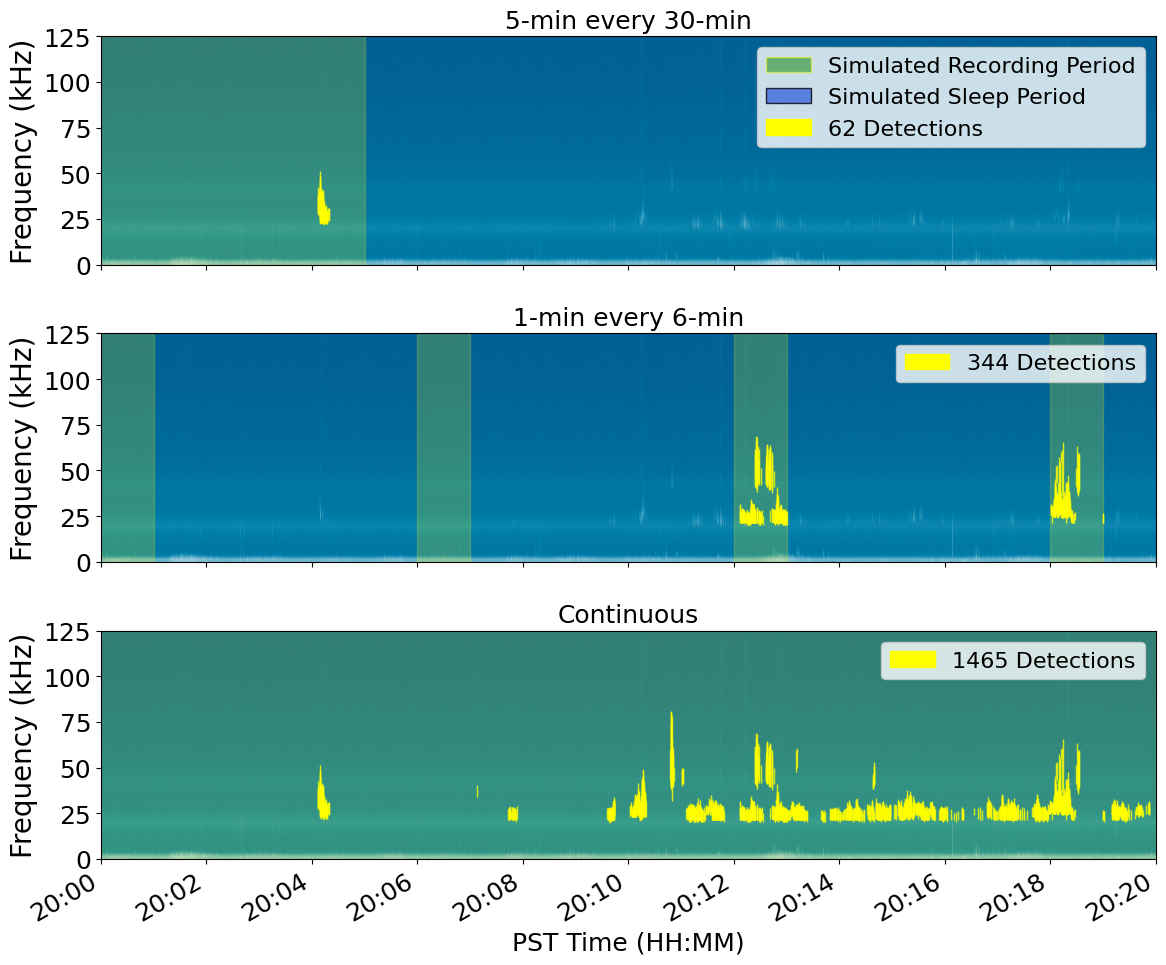

In [10]:
## Plot detections on audio
# Read in only section of audio with reftimes
# Zoom into section of audio with times

plt.figure(figsize=(12, 10))

cycle_length = 1800
percent_on = 0.167
dets = pd.read_csv(f"../output_dir/{int(cycle_length*percent_on)//60}min_every_{cycle_length//60}min__{location.split()[0]}_{date}_030000.csv")
plot_dets = dets[dets['input_file']==plot_file]
plt.subplot(311)
plt.title("5-min every 30-min", fontsize=18)
ss.plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=True, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=False, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

cycle_length = 360
percent_on = 0.167
dets2 = pd.read_csv(f"../output_dir/{int(cycle_length*percent_on)//60}min_every_{cycle_length//60}min__{location.split()[0]}_{date}_030000.csv")
plot_dets = dets2[dets2['input_file']==plot_file]
plt.subplot(312)
plt.title("1-min every 6-min", fontsize=18)
ss.plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=False, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=True, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

cycle_length = 1800
percent_on = 1.0
c_dets = pd.read_csv(f"../output_dir/continuous__{location.split()[0]}_{date}_030000.csv")
plot_dets = c_dets[c_dets['input_file']==plot_file]
plt.subplot(313)
plt.title("Continuous", fontsize=18)
ss.plt_msds_fromdf(location, plot_file, plot_dets, audio_sec, fs, offset, reftimes, times, cycle_length, percent_on, be_subplot=True, show_PST=True, show_legend=False, show_threshold=False, lf_threshold=45000, hf_threshold=35000, show_num_dets=True, det_linewidth=1, show_audio=False, show_spectrogram=True, spec_cmap='ocean', rm_dB=220, save=False)
plt.yticks(np.linspace(0, fs/2, 6), np.linspace(0, fs/2000, 6).astype('int'))

plt.tight_layout()
plt.show()

## 6) Running subsampling on continuous-scheme detection .csv files

In [13]:
c_dets = pd.read_csv(f"../output_dir/continuous__{location.split()[0]}_{date}_030000.csv")

def simulate_dutycycle_on_dets(dets, cycle_length, percent_on)
    dc_dets = dets.loc[np.logical_and((c_dets['start_time']%cycle_length)>=0, (c_dets['end_time']%cycle_length)<=int(cycle_length*percent_on))]
    return dc_dets

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
379,726.5015,726.5129,24609.0,31793.0,0.570,Echolocation,20210910_030000.WAV
380,726.6575,726.6712,23750.0,30947.0,0.510,Echolocation,20210910_030000.WAV
381,727.0355,727.0591,21171.0,27033.0,0.528,Echolocation,20210910_030000.WAV
382,727.3045,727.3254,21171.0,28485.0,0.564,Echolocation,20210910_030000.WAV
383,727.8175,727.8405,21171.0,27830.0,0.550,Echolocation,20210910_030000.WAV
...,...,...,...,...,...,...,...
2255,1498.2985,1498.3119,23750.0,28609.0,0.673,Echolocation,20210910_030000.WAV
2256,1498.7365,1498.7499,24609.0,28873.0,0.588,Echolocation,20210910_030000.WAV
2257,1499.2145,1499.2291,23750.0,28587.0,0.648,Echolocation,20210910_030000.WAV
2258,1499.5175,1499.5324,23750.0,28491.0,0.590,Echolocation,20210910_030000.WAV
